In [3]:
####git에 올릴 버전####

In [1]:
!pip install seaborn

In [4]:
import pandas as pd
import numpy as np
!pip install torch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [23]:
################################
####결측치 제거, 이상치 제거x####
#################################

In [5]:
import pandas as pd
import numpy as np

data = pd.read_csv("data/waze_dataset.csv", index_col=0)

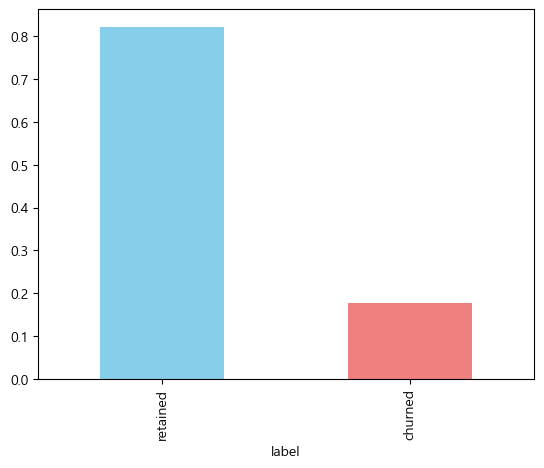

In [6]:
# Target 분포 확인
data['label'].value_counts(normalize = True).plot(kind = 'bar', color = ['skyblue', 'lightcoral']);

In [7]:
# DataLoad 함수

# %%writefile dataloader.py

import pandas as pd

def load_dataset():
    data = pd.read_csv('data/preprocessed.csv')
    data.columns = data.columns.str.lower()
    data = data.drop(data.columns[0], axis=1)
    X = data.drop(columns='label')
    y = data['label']
    
    return X, y

In [8]:
X, y = load_dataset()
print(X.head()) 
print(y.head())

   sessions  drives  total_sessions  n_days_after_onboarding  \
0       283     226      296.748273                     2276   
1       133     107      326.896596                     1225   
2       114      95      135.522926                     2651   
3        49      40       67.589221                       15   
4        84      68      168.247020                     1562   

   total_navigations_fav1  total_navigations_fav2  driven_km_drives  \
0                     208                       0       2628.845068   
1                      19                      64      13715.920550   
2                       0                       0       3059.148818   
3                     322                       7        913.591123   
4                     166                       5       3950.202008   

   duration_minutes_drives  activity_days  driving_days  device_android  \
0              1985.775061             28            19            True   
1              3160.472914            

In [9]:
# !pip install dataloader

In [10]:
# dataset 준비
from sklearn.model_selection import train_test_split

# X, y 분리
X, y = load_dataset()

# train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state=0)
# train/valid
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, stratify=y_train, random_state=0)

In [15]:
# Baseline model

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

models = [
    ("LR", LogisticRegression(random_state=0, max_iter=3000)),
    ("GBM", GradientBoostingClassifier(random_state=0)),
    ("RF", RandomForestClassifier(random_state=0)),
    ("XGB", XGBClassifier(random_state=0))
]

In [16]:
# 학습

baseline_result_train_dict = {}
baseline_result_valid_dict = {}


for name, model in models:
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    
    pred_valid = model.predict(X_valid)
    pred_proba_valid = model.predict_proba(X_valid)[:, 1]

    accuracy_valid = accuracy_score(y_valid, pred_valid)
    precision_valid = precision_score(y_valid, pred_valid)
    recall_valid = recall_score(y_valid, pred_valid)
    f1_valid = f1_score(y_valid, pred_valid)
    auc_valid = roc_auc_score(y_valid, pred_proba_valid)
    
    baseline_result_valid_dict[name] = [accuracy_valid, precision_valid, recall_valid, f1_valid, auc_valid]

Training LR...
Training GBM...
Training RF...
Training XGB...


In [17]:
# result

pd.DataFrame(baseline_result_valid_dict, index=['accuracy', 'precision', 'recall', 'f1', 'roc-auc'])

,LR,GBM,RF,XGB
accuracy,0.828322,0.824476,0.821678,0.811189
precision,0.836831,0.834962,0.835213,0.838625
recall,0.983000,0.980450,0.975776,0.954101
f1,0.904045,0.901876,0.900039,0.892644
roc-auc,0.758722,0.752880,0.732124,0.709396


In [26]:
#rou-auc는 불균형데이터에서 모델의 분류 능력을 평가할 때 유용
#rou-auc 기준으로 LR과 GBM의 성능이 높으므로 둘을 기준으로 하이퍼파라미터 튜닝 진행

In [24]:
######################
####하이퍼파라미터####
#####################

In [27]:
#실행시 시간 오래걸림 주의#
#4700초 걸림#
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

# LogisticRegression 하이퍼파라미터 그리드
param_lr = {
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'solver': ['liblinear', 'saga'],
    'penalty': ['l1', 'l2'],
    'max_iter': [100, 500, 1000] #크게의미x
}

# GradientBoostingClassifier 하이퍼파라미터 그리드
param_gbm = {
    'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5],
    'n_estimators': [100, 500, 1000, 2000],
    'max_depth': range(1, 6),
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1]
}

# 반복 횟수 설정
n_iterations = 5  # RandomizedSearchCV를 반복할 횟수
best_params_lr = None
best_score_lr = 0
best_params_gbm = None
best_score_gbm = 0

# 결과 저장을 위한 리스트
all_results_lr = []
all_results_gbm = []

for i in range(n_iterations):
    print(f"\nIteration {i + 1}/{n_iterations}")

    # LogisticRegression RandomizedSearchCV
    random_search_lr = RandomizedSearchCV(
        LogisticRegression(random_state=0), 
        param_lr, 
        cv=4, 
        scoring='roc_auc', 
        n_jobs=-1, 
        n_iter=50, 
        random_state=i  # 매 반복마다 다른 random_state 설정
    )
    random_search_lr.fit(X_train, y_train)
    all_results_lr.append((random_search_lr.best_params_, random_search_lr.best_score_))
    
    # 최고 점수 갱신
    if random_search_lr.best_score_ > best_score_lr:
        best_score_lr = random_search_lr.best_score_
        best_params_lr = random_search_lr.best_params_

    # GradientBoostingClassifier RandomizedSearchCV
    random_search_gbm = RandomizedSearchCV(
        GradientBoostingClassifier(random_state=0), 
        param_gbm, 
        cv=4, 
        scoring='roc_auc',
        n_jobs=-1, 
        n_iter=50, 
        random_state=i
    )
    random_search_gbm.fit(X_train, y_train)
    all_results_gbm.append((random_search_gbm.best_params_, random_search_gbm.best_score_))
    
    # 최고 점수 갱신
    if random_search_gbm.best_score_ > best_score_gbm:
        best_score_gbm = random_search_gbm.best_score_
        best_params_gbm = random_search_gbm.best_params_

# 최종 결과 출력
print("\nLogistic Regression 최적의 파라미터:", best_params_lr)
print("Logistic Regression 최고 ROC-AUC 점수:", best_score_lr)

print("\nGradient Boosting 최적의 파라미터:", best_params_gbm)
print("Gradient Boosting 최고 ROC-AUC 점수:", best_score_gbm)



Iteration 1/5

Iteration 2/5

Iteration 3/5

Iteration 4/5

Iteration 5/5

Logistic Regression 최적의 파라미터: {'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 500, 'C': 10}
Logistic Regression 최고 ROC-AUC 점수: 0.7567003886079537

Gradient Boosting 최적의 파라미터: {'subsample': 0.5, 'n_estimators': 2000, 'max_depth': 1, 'learning_rate': 0.01}
Gradient Boosting 최고 ROC-AUC 점수: 0.7523617653929704


In [28]:
#모델학습
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import pandas as pd

# 최적 파라미터로 모델 초기화
best_logistic_regression = LogisticRegression(
    solver='liblinear', 
    penalty='l2', 
    max_iter=500, 
    C=10, 
    random_state=0
)

best_gradient_boosting = GradientBoostingClassifier(
    subsample=0.5, 
    n_estimators=2000, 
    max_depth=1, 
    learning_rate=0.01, 
    random_state=0
)

# 모델 학습
best_logistic_regression.fit(X_train, y_train)
best_gradient_boosting.fit(X_train, y_train)

# 테스트 데이터 예측
y_pred_lr = best_logistic_regression.predict(X_test)
y_pred_lr_proba = best_logistic_regression.predict_proba(X_test)[:, 1]

y_pred_gbm = best_gradient_boosting.predict(X_test)
y_pred_gbm_proba = best_gradient_boosting.predict_proba(X_test)[:, 1]

# 평가 지표 계산
results = {
    "Metric": ["accuracy", "precision", "recall", "f1", "auc"],
    "Logistic Regression": [
        accuracy_score(y_test, y_pred_lr),
        precision_score(y_test, y_pred_lr),
        recall_score(y_test, y_pred_lr),
        f1_score(y_test, y_pred_lr),
        roc_auc_score(y_test, y_pred_lr_proba)
    ],
    "GradientBoostingClassifier": [
        accuracy_score(y_test, y_pred_gbm),
        precision_score(y_test, y_pred_gbm),
        recall_score(y_test, y_pred_gbm),
        f1_score(y_test, y_pred_gbm),
        roc_auc_score(y_test, y_pred_gbm_proba)
    ]
}

# 결과를 데이터프레임으로 출력
results_df = pd.DataFrame(results)
print(results_df)


      Metric  Logistic Regression  GradientBoostingClassifier
0   accuracy             0.826224                    0.824825
1  precision             0.834294                    0.832854
2     recall             0.984275                    0.984700
3         f1             0.903100                    0.902434
4        auc             0.744959                    0.740818


In [25]:
###################
####임계값 조정####
###################

In [22]:
# 임계값 리스트 정의
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]

# 결과 저장 딕셔너리 초기화
baseline_result_valid_dict = {}

for name, model in models:
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    
    # 예측 확률 생성
    pred_proba_valid = model.predict_proba(X_valid)[:, 1]

    # 각 임계값에 대해 성능 평가
    for threshold in thresholds:
        # 임계값 적용하여 예측 생성
        pred_valid = (pred_proba_valid >= threshold).astype(int)
        
        # 성능 평가
        accuracy_valid = accuracy_score(y_valid, pred_valid)
        precision_valid = precision_score(y_valid, pred_valid)
        recall_valid = recall_score(y_valid, pred_valid)
        f1_valid = f1_score(y_valid, pred_valid)
        auc_valid = roc_auc_score(y_valid, pred_proba_valid)  # ROC-AUC는 확률 기반으로 계산
        
        # 결과 저장 (각 모델 이름과 임계값을 키로 사용)
        baseline_result_valid_dict[(name, threshold)] = [
            accuracy_valid, precision_valid, recall_valid, f1_valid, auc_valid
        ]

# 결과 출력
import pandas as pd
results_df = pd.DataFrame(baseline_result_valid_dict, index=["Accuracy", "Precision", "Recall", "F1 Score", "ROC-AUC"]).T
print(results_df)

Training LR...
Training GBM...
Training RF...
Training XGB...
         Accuracy  Precision    Recall  F1 Score   ROC-AUC
LR  0.3  0.822378   0.822891  0.999150  0.902495  0.758722
    0.4  0.823427   0.825581  0.995750  0.902716  0.758722
    0.5  0.828322   0.836831  0.983000  0.904045  0.758722
    0.6  0.825175   0.855935  0.946876  0.899112  0.758722
    0.7  0.797902   0.883701  0.868678  0.876125  0.758722
GBM 0.3  0.823077   0.823241  0.999575  0.902879  0.752880
    0.4  0.824126   0.825934  0.996175  0.903102  0.752880
    0.5  0.824476   0.834962  0.980450  0.901876  0.752880
    0.6  0.827273   0.855178  0.951126  0.900604  0.752880
    0.7  0.793357   0.881055  0.865703  0.873312  0.752880
RF  0.3  0.822378   0.822665  0.999575  0.902533  0.732124
    0.4  0.823776   0.824728  0.997875  0.903077  0.732124
    0.5  0.822727   0.834663  0.978326  0.900802  0.732124
    0.6  0.812587   0.854467  0.930727  0.890968  0.732124
    0.7  0.770280   0.877560  0.837654  0.857143  0.7

In [20]:
#roc-auc는 임계값 조정과 상관없기 때문에 값이 변하지 않음

In [ ]:
##################################
####모델 별 feature importance####
##################################

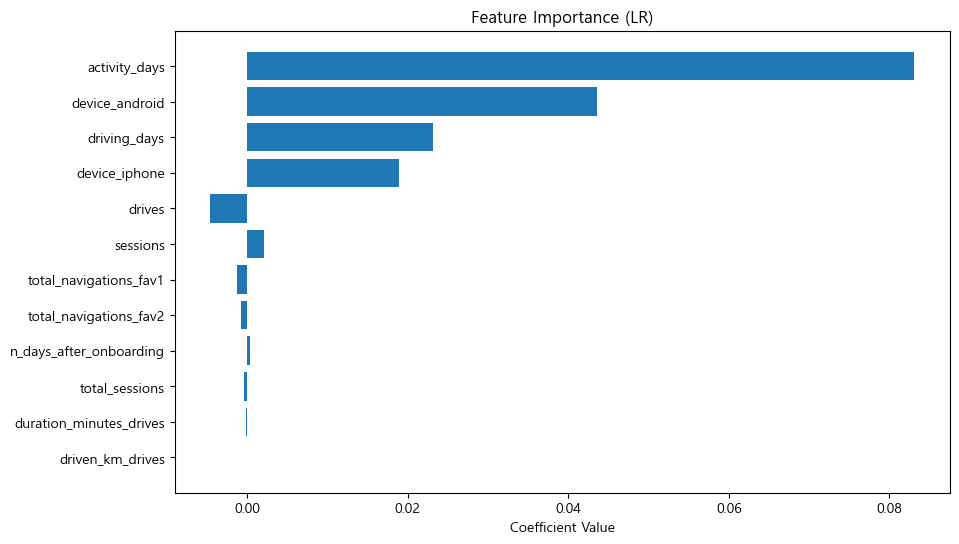

In [29]:
# LR feature importance
import matplotlib.pyplot as plt
import numpy as np

model_lr = LogisticRegression(random_state=0, max_iter=3000)

model_lr.fit(X_train, y_train)

# coefficient

coefficients = model_lr.coef_[0]
indices = np.argsort(np.abs(coefficients))  
plt.figure(figsize=(10, 6))
plt.title("Feature Importance (LR)")
plt.barh(range(len(indices)), coefficients[indices], align="center")
plt.yticks(range(len(indices)), [X_train.columns[i] for i in indices])
plt.xlabel("Coefficient Value")
plt.show()

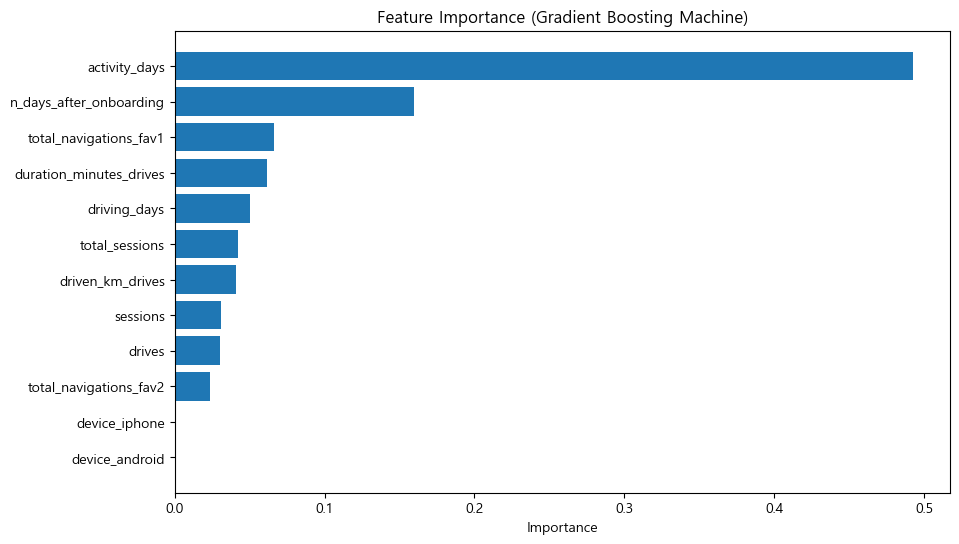

In [30]:
# gbm feature importance
from sklearn.ensemble import GradientBoostingClassifier

# Gradient Boosting 모델 학습
model_gbm = GradientBoostingClassifier(random_state=0)

model_gbm.fit(X_train, y_train)

# feature_importances_를 통한 피처 중요도 시각화
importance = model_gbm.feature_importances_
indices = np.argsort(importance)
plt.figure(figsize=(10, 6))
plt.title("Feature Importance (Gradient Boosting Machine)")
plt.barh(range(len(indices)), importance[indices], align="center")
plt.yticks(range(len(indices)), [X_train.columns[i] for i in indices])
plt.xlabel("Importance")
plt.show()


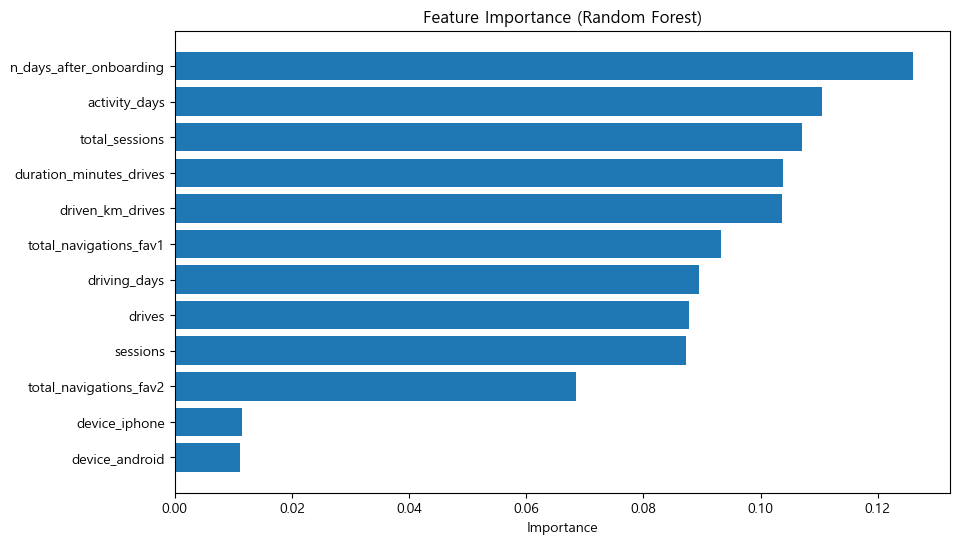

In [31]:
# rf feature importance
from sklearn.ensemble import RandomForestClassifier

# Random Forest 모델 학습
model_rf = RandomForestClassifier(random_state=0)

model_rf.fit(X_train, y_train)

# feature_importances_를 통한 피처 중요도 시각화
importance = model_rf.feature_importances_
indices = np.argsort(importance)
plt.figure(figsize=(10, 6))
plt.title("Feature Importance (Random Forest)")
plt.barh(range(len(indices)), importance[indices], align="center")
plt.yticks(range(len(indices)), [X_train.columns[i] for i in indices])
plt.xlabel("Importance")
plt.show()


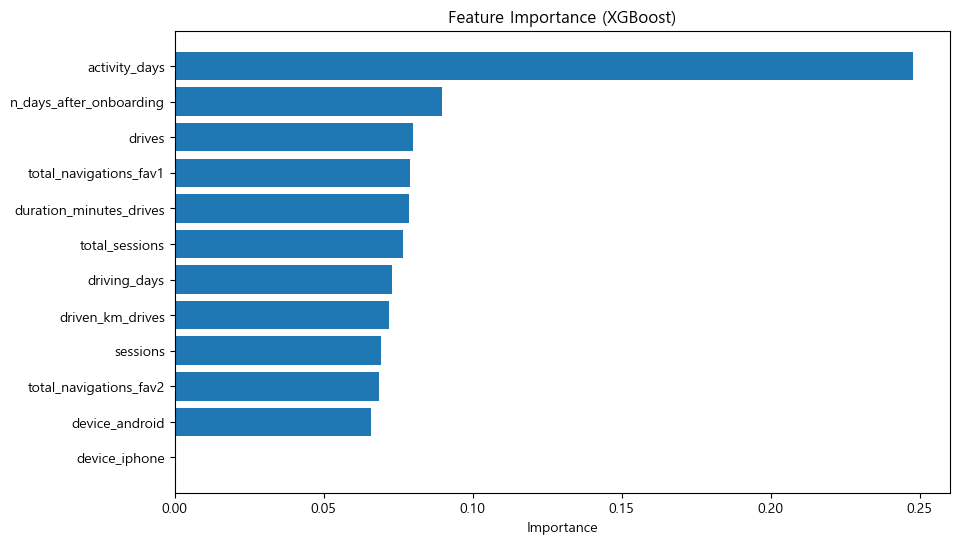

In [32]:
# xbg feature importance
from xgboost import XGBClassifier

# XGBoost 모델 학습
model_xgb = XGBClassifier(random_state=0)

model_xgb.fit(X_train, y_train)

# feature_importances_를 통한 피처 중요도 시각화
importance = model_xgb.feature_importances_
indices = np.argsort(importance)
plt.figure(figsize=(10, 6))
plt.title("Feature Importance (XGBoost)")
plt.barh(range(len(indices)), importance[indices], align="center")
plt.yticks(range(len(indices)), [X_train.columns[i] for i in indices])
plt.xlabel("Importance")
plt.show()


In [ ]:
# GBM, RF feature importance 기반으로 무의미하다고 판단되는 feature(device) 삭제

In [ ]:
####데이터 전처리 실패로 인한 ,, 중지

In [ ]:
# DataLoad 함수

# %%writefile dataloader.py

import pandas as pd

def load_dataset():
    data = pd.read_csv('data/preprocessed.csv')
    data.columns = data.columns.str.lower()
    data = data.drop(data.columns[0], axis=1)
    X = data.drop(columns='label')
    y = data['label']
    
    return X, y

In [ ]:
# dataset 준비
from sklearn.model_selection import train_test_split

# X, y 분리
X, y = load_dataset()

# train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state=0)
# train/valid
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, stratify=y_train, random_state=0)

In [ ]:
# Baseline model

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

models = [
    ("LR", LogisticRegression(random_state=0, max_iter=3000)),
    ("GBM", GradientBoostingClassifier(random_state=0)),
    ("RF", RandomForestClassifier(random_state=0)),
    ("XGB", XGBClassifier(random_state=0))
]

In [ ]:
# 학습

baseline_result_train_dict = {}
baseline_result_valid_dict = {}


for name, model in models:
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    
    pred_valid = model.predict(X_valid)
    pred_proba_valid = model.predict_proba(X_valid)[:, 1]

    accuracy_valid = accuracy_score(y_valid, pred_valid)
    precision_valid = precision_score(y_valid, pred_valid)
    recall_valid = recall_score(y_valid, pred_valid)
    f1_valid = f1_score(y_valid, pred_valid)
    auc_valid = roc_auc_score(y_valid, pred_proba_valid)
    
    baseline_result_valid_dict[name] = [accuracy_valid, precision_valid, recall_valid, f1_valid, auc_valid]

In [ ]:
# result

pd.DataFrame(baseline_result_valid_dict, index=['accuracy', 'precision', 'recall', 'f1', 'roc-auc'])